In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

In [45]:
# in general, one would use "cuda" if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [46]:
W,H=8,8 # height and width of resize images (input size for CNN)
C=1 # input channels (gray image)
batch_size = 64

# Define a transformation to flatten the 8x8 images
transform = transforms.Compose([
    transforms.Resize((W, H)),         # Resize the PIL Image to 8x8 first (MNIST images are originally 28x28)
    transforms.ToTensor(),             # Then convert to tensor
])

In [56]:
# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

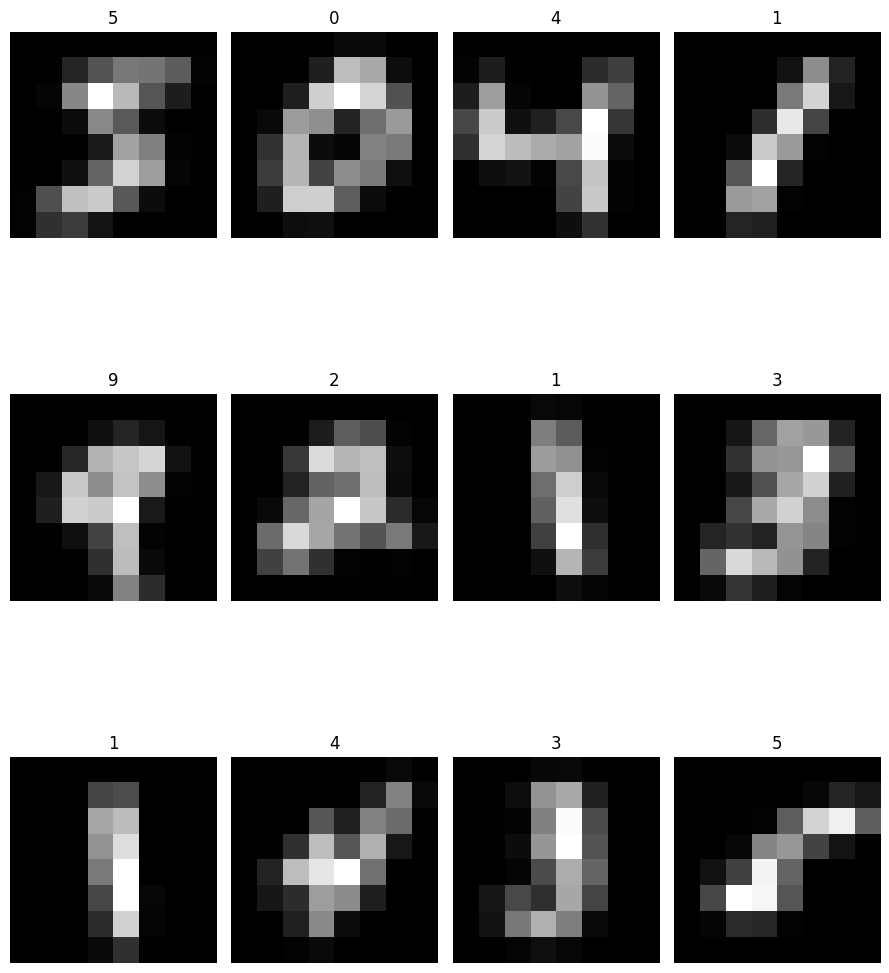

In [48]:
# Assuming each image has shape (C,W,H)=(1, 8, 8)
images, labels = zip(*[train_dataset[i] for i in range(12)])

fig, axes = plt.subplots(3, 4, figsize=(9, 12))
for i, ax in enumerate(axes.flat):
    img = images[i].squeeze(0) # Remove the channel dimension (1,) -> (8, 8)
    ax.imshow(img, cmap='gray')
    ax.set_title(str(labels[i]), fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [49]:
# Convolutional block with batch normalization: ic=input channels; oc=output channels
def conv(ic, oc, act=True):
    ks = 3
    layers = [
        nn.Conv2d(ic, oc, stride=2, kernel_size=ks, padding=ks//2),
        nn.BatchNorm2d(oc)  # insert nn.BatchNorm2d layer after each convolution and before the activation (ReLU).
    ]
    return nn.Sequential(*layers)

# Build the CNN model with layers of conv(ic,oc) and Dropout
ks = 3
simple_cnn = nn.Sequential(
    conv(1, 8),              # convolution and batchnorm; Output: 4x4
    nn.Dropout2d(p=0.25),    # Add 2D Dropout after the first conv layer (common for CNNs)
    nn.ReLU(),               # activation layer
    conv(8, 16),             # Output: 2x2
    nn.Dropout2d(p=0.25),    # Add 2D Dropout after the second conv layer
    nn.ReLU(),               # activation layer
    conv(16, 10, act=False), # Output: 1x1
    nn.Flatten(), # Use the predefined nn.Flatten layer
    # You could also add a standard nn.Dropout here if you had a fully connected layer after Flatten,
    # but in this specific architecture, Flatten is followed directly by the output layer.
)

In [50]:
# Computes the accuracy for a batch: outputs are probability-like values
def compute_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    total = len(labels)
    return correct / total

num_epochs = 10
model = simple_cnn

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model.to(device) #<<<<<<<<<< move model to device

# History object to keep track of accuracy along epochs
history = {'epoch': [], 'train_accuracy': [], 'val_accuracy': []}

In [ ]:
for epoch in range(num_epochs):
    print(f'epoch: {epoch+1}; time: {round(time.time())}')
    model.train()
    batch_accuracies=[] # to store estimated accuracy for each batch
    # loop through batches of examples
    for images, labels in train_loader:
        images = images.to(device)  #<<<<<<<<<< move data to device
        labels = labels.to(device)  #<<<<<<<<<< move data to device
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # compute accuracy over the batch
        batch_accuracies.append(compute_accuracy(outputs, labels))
    history['epoch'].append(epoch+1)
    history['train_accuracy'].append(sum(batch_accuracies) / len(batch_accuracies))
    print(f'epoch: {epoch+1}; accuracy: {sum(batch_accuracies) / len(batch_accuracies)}')
    
    # save current model before next epoch
    model_filename=f'MNIST-Classification/simple_cnn_jit_epoch_{epoch+1}.pt'
    # Save the trained model in JIT format <<<<<<<<<<<<<<<<<<<<<<<<<<<< JIT format
    model.eval() # Set the model to evaluation mode
    with torch.no_grad(): # Disable gradient calculation for JIT tracing
        # Create a dummy input matching the expected input shape of the model
        dummy_input = torch.randn(1, C, W, H).to(device)
        # Trace the model with the dummy input
        traced_model = torch.jit.trace(model, dummy_input)
    # Save the traced model to a file
    traced_model.save(model_filename)

epoch: 1; time: 1750334121
epoch: 1; accuracy: 0.7182502665245203
epoch: 2; time: 1750334138
epoch: 2; accuracy: 0.8297741204690832
epoch: 3; time: 1750334156
epoch: 3; accuracy: 0.8484474946695096
epoch: 4; time: 1750334173
epoch: 4; accuracy: 0.8546941631130064
epoch: 5; time: 1750334191
epoch: 5; accuracy: 0.8601912313432836
epoch: 6; time: 1750334208
epoch: 6; accuracy: 0.8629397654584222
epoch: 7; time: 1750334227
epoch: 7; accuracy: 0.865271855010661
epoch: 8; time: 1750334244
epoch: 8; accuracy: 0.8657715884861408
epoch: 9; time: 1750334261
epoch: 9; accuracy: 0.8657382729211087
epoch: 10; time: 1750334278
epoch: 10; accuracy: 0.8679204424307037


In [ ]:
history['val_accuracy']=[]
for epoch in range(num_epochs):
    print(f'epoch: {epoch+1}; time: {round(time.time())}')
    # Define the path to the saved JIT model file
    jit_model_filename = f'MNIST-Classification/models/simple_cnn_jit_epoch_{epoch+1}.pt'
    # Load the traced model from the file
    # Ensure the model is loaded onto the correct device
    model = torch.jit.load(jit_model_filename, map_location=device)
    print(f"Model loaded from {jit_model_filename}")
    model.eval() # Set the loaded model to evaluation mode
    batch_accuracies=[]
    with torch.no_grad():
        # loop through batches of examples
        for images, labels in test_loader:
            images = images.to(device)  #<<<<<<<<<< move data to device
            labels = labels.to(device)  #<<<<<<<<<< move data to device
            outputs = model(images)
            # compute accuracy over the batch
            batch_accuracies.append(compute_accuracy(outputs, labels))
        history['val_accuracy'].append(sum(batch_accuracies) / len(batch_accuracies))
        print(f'epoch: {epoch+1}; accuracy: {sum(batch_accuracies) / len(batch_accuracies)}')

epoch: 1; time: 1750334295
Model loaded from MNIST-Classification/simple_cnn_jit_epoch_1.pt
epoch: 1; accuracy: 0.9121218152866242
epoch: 2; time: 1750334298
Model loaded from MNIST-Classification/simple_cnn_jit_epoch_2.pt
epoch: 2; accuracy: 0.9239649681528662
epoch: 3; time: 1750334300
Model loaded from MNIST-Classification/simple_cnn_jit_epoch_3.pt
epoch: 3; accuracy: 0.9292396496815286
epoch: 4; time: 1750334302
Model loaded from MNIST-Classification/simple_cnn_jit_epoch_4.pt
epoch: 4; accuracy: 0.9368033439490446
epoch: 5; time: 1750334305
Model loaded from MNIST-Classification/simple_cnn_jit_epoch_5.pt
epoch: 5; accuracy: 0.9357085987261147
epoch: 6; time: 1750334307
Model loaded from MNIST-Classification/simple_cnn_jit_epoch_6.pt
epoch: 6; accuracy: 0.9407842356687898
epoch: 7; time: 1750334309
Model loaded from MNIST-Classification/simple_cnn_jit_epoch_7.pt
epoch: 7; accuracy: 0.9418789808917197
epoch: 8; time: 1750334311
Model loaded from MNIST-Classification/simple_cnn_jit_ep

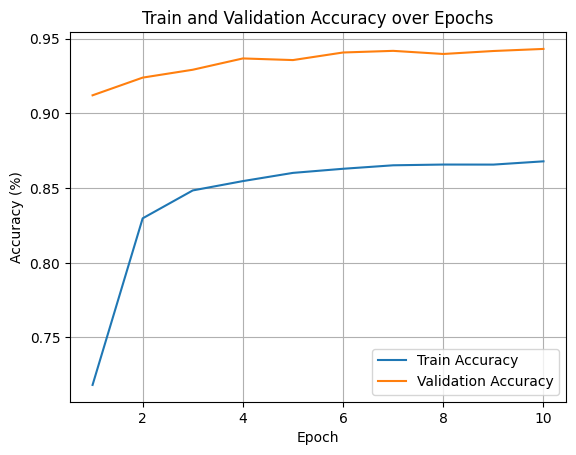

In [53]:
# accuracy plot
plt.plot(history['epoch'], history['train_accuracy'], label='Train Accuracy')
plt.plot(history['epoch'], history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()